<a href="https://colab.research.google.com/github/Ganesh10S/Scene-Segmentation-of-urban-and-rural-from-Remote-Sensing/blob/master/Scene_Segmentation_of_urban_and_rural_from_remote_sensing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
  #  !pip install -U -q kaggle
#!mkdir -p ~/.kaggle

In [0]:
#chmod 600 /root/.kaggle/kaggle.json

In [0]:
#from google.colab import files
#files.upload()

In [0]:
#!cp kaggle.json ~/.kaggle/


In [0]:
#!kaggle datasets list

In [0]:
#!kaggle datasets download -d bkfateam/potsdamvaihingen

In [0]:
#!unzip potsdamvaihingen.zip -d /content/drive/My\ Drive/VP\ DATASET

In [0]:
import numpy as np                           #to operate high level mathematical function in an array
from skimage import io                       #io to read ,save ,display a image
from glob import glob                        #finds all path name matching a specific pattern
from tqdm import tqdm_notebook as tqdm       #to show progress of each loop
from sklearn.metrics import confusion_matrix
import random                                #generates random numbers  
import itertools                             #to produce complex iterators
# Matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# Torch imports
import torch                                 #scientific computing package
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
import torch.optim.lr_scheduler
import torch.nn.init
from torch.autograd import Variable

In [0]:
WINDOW_SIZE = (256, 256) # Patch size
STRIDE = 32 # Stride for testing
IN_CHANNELS = 3 # Number of input channels (e.g. RGB)
FOLDER = "/content/drive/My Drive/VP DATASET" # Replace with your "/path/to/the/ISPRS/dataset/folder/"
BATCH_SIZE = 10 # Number of samples in a mini-batch

LABELS = ["roads", "buildings", "low veg.", "trees", "cars", "clutter"] # Label names
N_CLASSES = len(LABELS) # Number of classes
WEIGHTS = torch.ones(N_CLASSES) # Weights for class balancing
CACHE = True # Store the dataset in-memory

DATASET = 'Vaihingen'         #vaihingen dataset

if DATASET == 'Potsdam':
    MAIN_FOLDER = '/content/drive/My Drive/VP DATASET/'
    # Uncomment the next line for IRRG data
    # DATA_FOLDER = MAIN_FOLDER + '3_Ortho_IRRG/top_potsdam_{}_IRRG.tif'
    # For RGB data
    DATA_FOLDER = MAIN_FOLDER + '/3_Ortho_IRRG/3_Ortho_IRRG/' + '/top_potsdam_{}_RGB.tif'
    LABEL_FOLDER = MAIN_FOLDER + '/5_Labels_for_participants/' + '/top_potsdam_{}_label.tif'
    ERODED_FOLDER = MAIN_FOLDER + '5_Labels_for_participants_no_Boundary/' + '/top_potsdam_{}_label_noBoundary.tif'    
elif DATASET == 'Vaihingen':
    MAIN_FOLDER = '/content/drive/My Drive/VP DATASET/ISPRS_semantic_labeling_Vaihingen/'
    DATA_FOLDER = MAIN_FOLDER + 'top/top_mosaic_09cm_area{}.tif'
    LABEL_FOLDER = '/content/drive/My Drive/VP DATASET/ISPRS_semantic_labeling_Vaihingen/' +'/gts_for_participants/top_mosaic_09cm_area{}.tif'
    ERODED_FOLDER = '/content/drive/My Drive/VP DATASET/ISPRS_semantic_labeling_Vaihingen/' +'/gts_for_participants/top_mosaic_09cm_area{}.tif'

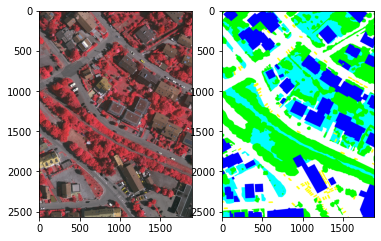

Ground truth in numerical format has shape (2566,1893) : 
 [[3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 [3 3 3 ... 3 3 3]
 ...
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]
 [2 2 2 ... 1 1 1]]


In [10]:
# ISPRS color palette
# Let's define the standard ISPRS color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # Low vegetation (cyan)
           3 : (0, 255, 0),     # Trees (green)
           4 : (255, 255, 0),   # Cars (yellow)
           5 : (255, 0, 0),     # Clutter (red)
           6 : (0, 0, 0)}       # Undefined (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d

# We load one tile from the dataset and we display it
img = io.imread('/content/drive/My Drive/VP DATASET/ISPRS_semantic_labeling_Vaihingen/top/top_mosaic_09cm_area11.tif')
fig = plt.figure()
fig.add_subplot(121)
plt.imshow(img)

# We load the ground truth
gt = io.imread('/content/drive/My Drive/VP DATASET/ISPRS_semantic_labeling_Vaihingen/gts_for_participants/top_mosaic_09cm_area11.tif')
fig.add_subplot(122)
plt.imshow(gt)
plt.show()

# We also check that we can convert the ground truth into an array format
array_gt = convert_from_color(gt)
print("Ground truth in numerical format has shape ({},{}) : \n".format(*array_gt.shape[:2]), array_gt)


In [0]:
# Utils

def get_random_pos(img, window_shape):
    """ Extract of 2D random patch of shape window_shape in the image """
    w, h = window_shape
    W, H = img.shape[-2:]
    x1 = random.randint(0, W - w - 1)
    x2 = x1 + w
    y1 = random.randint(0, H - h - 1)
    y2 = y1 + h
    return x1, x2, y1, y2

def CrossEntropy2d(input, target, weight=None, size_average=True):
    """ 2D version of the cross entropy loss """
    dim = input.dim()
    if dim == 2:
        return F.cross_entropy(input, target, weight, size_average)
    elif dim == 4:
        output = input.view(input.size(0),input.size(1), -1)
        output = torch.transpose(output,1,2).contiguous()
        output = output.view(-1,output.size(2))
        target = target.view(-1)
        return F.cross_entropy(output, target,weight, size_average)
    else:
        raise ValueError('Expected 2 or 4 dimensions (got {})'.format(dim))

def accuracy(input, target):
    return 100 * float(np.count_nonzero(input == target)) / target.size

def sliding_window(top, step=10, window_size=(20,20)):
    """ Slide a window_shape window across the image with a stride of step """
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            yield x, y, window_size[0], window_size[1]
            
def count_sliding_window(top, step=10, window_size=(20,20)):
    """ Count the number of windows in an image """
    c = 0
    for x in range(0, top.shape[0], step):
        if x + window_size[0] > top.shape[0]:
            x = top.shape[0] - window_size[0]
        for y in range(0, top.shape[1], step):
            if y + window_size[1] > top.shape[1]:
                y = top.shape[1] - window_size[1]
            c += 1
    return c

def grouper(n, iterable):
    """ Browse an iterator by chunk of n elements """
    it = iter(iterable)
    while True:
        chunk = tuple(itertools.islice(it, n))
        if not chunk:
            return
        yield chunk

def metrics(predictions, gts, label_values=LABELS):
    cm = confusion_matrix(
            gts,
            predictions,
            range(len(label_values)))
    
    print("Confusion matrix :")
    print(cm)
    
    print("---")
    
    # Compute global accuracy
    total = sum(sum(cm))
    accuracy = sum([cm[x][x] for x in range(len(cm))])
    accuracy *= 100 / float(total)
    print("{} pixels processed".format(total))
    print("Total accuracy : {}%".format(accuracy))
    
    print("---")
    
    # Compute F1 score
    F1Score = np.zeros(len(label_values))
    for i in range(len(label_values)):
        try:
            F1Score[i] = 2. * cm[i,i] / (np.sum(cm[i,:]) + np.sum(cm[:,i]))
        except:
            # Ignore exception if there is no element in class i for test set
            pass
    print("F1Score :")
    for l_id, score in enumerate(F1Score):
        print("{}: {}".format(label_values[l_id], score))

    print("---")
        
    # Compute kappa coefficient
    total = np.sum(cm)
    pa = np.trace(cm) / float(total)
    pe = np.sum(np.sum(cm, axis=0) * np.sum(cm, axis=1)) / float(total*total)
    kappa = (pa - pe) / (1 - pe);
    print("Kappa: " + str(kappa))
    return accuracy

In [0]:
class ISPRS_dataset(torch.utils.data.Dataset):
    def __init__(self, ids, data_files=DATA_FOLDER, label_files=LABEL_FOLDER,
                            cache=False, augmentation=True):
        super(ISPRS_dataset, self).__init__()
        
        self.augmentation = augmentation
        self.cache = cache
        
        # List of files
        self.data_files = [DATA_FOLDER.format(id) for id in ids]
        self.label_files = [LABEL_FOLDER.format(id) for id in ids]

        # Sanity check : raise an error if some files do not exist
        for f in self.data_files + self.label_files:
            if not os.path.isfile(f):
                raise KeyError('{} is not a file !'.format(f))
        
        # Initialize cache dicts
        self.data_cache_ = {}
        self.label_cache_ = {}
            
    
    def __len__(self):
        # Default epoch size is 10 000 samples
        return 10000
    
    @classmethod
    def data_augmentation(cls, *arrays, flip=True, mirror=True):
        will_flip, will_mirror = False, False
        if flip and random.random() < 0.5:
            will_flip = True
        if mirror and random.random() < 0.5:
            will_mirror = True
        
        results = []
        for array in arrays:
            if will_flip:
                if len(array.shape) == 2:
                    array = array[::-1, :]
                else:
                    array = array[:, ::-1, :]
            if will_mirror:
                if len(array.shape) == 2:
                    array = array[:, ::-1]
                else:
                    array = array[:, :, ::-1]
            results.append(np.copy(array))
            
        return tuple(results)
    
    def __getitem__(self, i):
        # Pick a random image
        random_idx = random.randint(0, len(self.data_files) - 1)
        
        # If the tile hasn't been loaded yet, put in cache
        if random_idx in self.data_cache_.keys():
            data = self.data_cache_[random_idx]
        else:
            # Data is normalized in [0, 1]
            data = 1/255 * np.asarray(io.imread(self.data_files[random_idx]).transpose((2,0,1)), dtype='float32')
            if self.cache:
                self.data_cache_[random_idx] = data
            
        if random_idx in self.label_cache_.keys():
            label = self.label_cache_[random_idx]
        else: 
            # Labels are converted from RGB to their numeric values
            label = np.asarray(convert_from_color(io.imread(self.label_files[random_idx])), dtype='int64')
            if self.cache:
                self.label_cache_[random_idx] = label

        # Get a random patch
        x1, x2, y1, y2 = get_random_pos(data, WINDOW_SIZE)
        data_p = data[:, x1:x2,y1:y2]
        label_p = label[x1:x2,y1:y2]
        
        # Data augmentation
        data_p, label_p = self.data_augmentation(data_p, label_p)

        # Return the torch.Tensor values
        return (torch.from_numpy(data_p),
                torch.from_numpy(label_p))

In [0]:
class SegNet(nn.Module):
    # SegNet network
    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal(m.weight.data)
    
    def __init__(self, in_channels=IN_CHANNELS, out_channels=N_CLASSES):
        super(SegNet, self).__init__()
        self.pool = nn.MaxPool2d(2, return_indices=True)
        self.unpool = nn.MaxUnpool2d(2)
        
        self.conv1_1 = nn.Conv2d(in_channels, 64, 3, padding=1)
        self.conv1_1_bn = nn.BatchNorm2d(64)
        self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_bn = nn.BatchNorm2d(64)
        
        self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv2_1_bn = nn.BatchNorm2d(128)
        self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_bn = nn.BatchNorm2d(128)
        
        self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_1_bn = nn.BatchNorm2d(256)
        self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_bn = nn.BatchNorm2d(256)
        self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_bn = nn.BatchNorm2d(256)
        
        self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
        self.conv4_1_bn = nn.BatchNorm2d(512)
        self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_bn = nn.BatchNorm2d(512)
        self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_bn = nn.BatchNorm2d(512)
        self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_bn = nn.BatchNorm2d(512)
        self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_bn = nn.BatchNorm2d(512)
        
        self.conv5_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_3_D_bn = nn.BatchNorm2d(512)
        self.conv5_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_2_D_bn = nn.BatchNorm2d(512)
        self.conv5_1_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv5_1_D_bn = nn.BatchNorm2d(512)
        
        self.conv4_3_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_3_D_bn = nn.BatchNorm2d(512)
        self.conv4_2_D = nn.Conv2d(512, 512, 3, padding=1)
        self.conv4_2_D_bn = nn.BatchNorm2d(512)
        self.conv4_1_D = nn.Conv2d(512, 256, 3, padding=1)
        self.conv4_1_D_bn = nn.BatchNorm2d(256)
        
        self.conv3_3_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_3_D_bn = nn.BatchNorm2d(256)
        self.conv3_2_D = nn.Conv2d(256, 256, 3, padding=1)
        self.conv3_2_D_bn = nn.BatchNorm2d(256)
        self.conv3_1_D = nn.Conv2d(256, 128, 3, padding=1)
        self.conv3_1_D_bn = nn.BatchNorm2d(128)
        
        self.conv2_2_D = nn.Conv2d(128, 128, 3, padding=1)
        self.conv2_2_D_bn = nn.BatchNorm2d(128)
        self.conv2_1_D = nn.Conv2d(128, 64, 3, padding=1)
        self.conv2_1_D_bn = nn.BatchNorm2d(64)
        
        self.conv1_2_D = nn.Conv2d(64, 64, 3, padding=1)
        self.conv1_2_D_bn = nn.BatchNorm2d(64)
        self.conv1_1_D = nn.Conv2d(64, out_channels, 3, padding=1)
        
        self.apply(self.weight_init)
        
    def forward(self, x):
        # Encoder block 1
        x = self.conv1_1_bn(F.relu(self.conv1_1(x)))
        x = self.conv1_2_bn(F.relu(self.conv1_2(x)))
        x, mask1 = self.pool(x)
        
        # Encoder block 2
        x = self.conv2_1_bn(F.relu(self.conv2_1(x)))
        x = self.conv2_2_bn(F.relu(self.conv2_2(x)))
        x, mask2 = self.pool(x)
        
        # Encoder block 3
        x = self.conv3_1_bn(F.relu(self.conv3_1(x)))
        x = self.conv3_2_bn(F.relu(self.conv3_2(x)))
        x = self.conv3_3_bn(F.relu(self.conv3_3(x)))
        x, mask3 = self.pool(x)
        
        # Encoder block 4
        x = self.conv4_1_bn(F.relu(self.conv4_1(x)))
        x = self.conv4_2_bn(F.relu(self.conv4_2(x)))
        x = self.conv4_3_bn(F.relu(self.conv4_3(x)))
        x, mask4 = self.pool(x)
        
        # Encoder block 5
        x = self.conv5_1_bn(F.relu(self.conv5_1(x)))
        x = self.conv5_2_bn(F.relu(self.conv5_2(x)))
        x = self.conv5_3_bn(F.relu(self.conv5_3(x)))
        x, mask5 = self.pool(x)
        
        # Decoder block 5
        x = self.unpool(x, mask5)
        x = self.conv5_3_D_bn(F.relu(self.conv5_3_D(x)))
        x = self.conv5_2_D_bn(F.relu(self.conv5_2_D(x)))
        x = self.conv5_1_D_bn(F.relu(self.conv5_1_D(x)))
        
        # Decoder block 4
        x = self.unpool(x, mask4)
        x = self.conv4_3_D_bn(F.relu(self.conv4_3_D(x)))
        x = self.conv4_2_D_bn(F.relu(self.conv4_2_D(x)))
        x = self.conv4_1_D_bn(F.relu(self.conv4_1_D(x)))
        
        # Decoder block 3
        x = self.unpool(x, mask3)
        x = self.conv3_3_D_bn(F.relu(self.conv3_3_D(x)))
        x = self.conv3_2_D_bn(F.relu(self.conv3_2_D(x)))
        x = self.conv3_1_D_bn(F.relu(self.conv3_1_D(x)))
        
        # Decoder block 2
        x = self.unpool(x, mask2)
        x = self.conv2_2_D_bn(F.relu(self.conv2_2_D(x)))
        x = self.conv2_1_D_bn(F.relu(self.conv2_1_D(x)))
        
        # Decoder block 1
        x = self.unpool(x, mask1)
        x = self.conv1_2_D_bn(F.relu(self.conv1_2_D(x)))
        x = F.log_softmax(self.conv1_1_D(x))
        return x

In [0]:
# instantiate the network
net = SegNet()

In [15]:
import os
try:
    from urllib.request import URLopener
except ImportError:
    from urllib import URLopener

# Download VGG-16 weights from PyTorch
vgg_url = 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth'
if not os.path.isfile('./vgg16_bn-6c64b313.pth'):
    weights = URLopener().retrieve(vgg_url, './vgg16_bn-6c64b313.pth')

vgg16_weights = torch.load('./vgg16_bn-6c64b313.pth')
mapped_weights = {}
for k_vgg, k_segnet in zip(vgg16_weights.keys(), net.state_dict().keys()):
    if "features" in k_vgg:
        mapped_weights[k_segnet] = vgg16_weights[k_vgg]
        print("Mapping {} to {}".format(k_vgg, k_segnet))
        
try:
    net.load_state_dict(mapped_weights)
    print("Loaded VGG-16 weights in SegNet !")
except:
    # Ignore missing keys
    pass

Mapping features.0.weight to conv1_1.weight
Mapping features.0.bias to conv1_1.bias
Mapping features.1.weight to conv1_1_bn.weight
Mapping features.1.bias to conv1_1_bn.bias
Mapping features.1.running_mean to conv1_1_bn.running_mean
Mapping features.1.running_var to conv1_1_bn.running_var
Mapping features.3.weight to conv1_1_bn.num_batches_tracked
Mapping features.3.bias to conv1_2.weight
Mapping features.4.weight to conv1_2.bias
Mapping features.4.bias to conv1_2_bn.weight
Mapping features.4.running_mean to conv1_2_bn.bias
Mapping features.4.running_var to conv1_2_bn.running_mean
Mapping features.7.weight to conv1_2_bn.running_var
Mapping features.7.bias to conv1_2_bn.num_batches_tracked
Mapping features.8.weight to conv2_1.weight
Mapping features.8.bias to conv2_1.bias
Mapping features.8.running_mean to conv2_1_bn.weight
Mapping features.8.running_var to conv2_1_bn.bias
Mapping features.10.weight to conv2_1_bn.running_mean
Mapping features.10.bias to conv2_1_bn.running_var
Mapping fe

In [16]:
net.cuda()

SegNet(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_1_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2_bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_1_bn): BatchNorm2d(256, eps=1e-05, mom

In [17]:
# Load the datasets
if DATASET == 'Potsdam':
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = ["".join(f.split('')[5:7]) for f in all_files]
elif DATASET == 'Vaihingen':
    #all_ids = 
    all_files = sorted(glob(LABEL_FOLDER.replace('{}', '*')))
    all_ids = [f.split('area')[-1].split('.')[0] for f in all_files]
# Random tile numbers for train/test split
train_ids = random.sample(all_ids, 2 * len(all_ids) // 3 + 1)
test_ids = list(set(all_ids) - set(train_ids))

# Exemple of a train/test split on Vaihingen :
train_ids = ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
test_ids = ['5', '21', '15', '30'] 

print("Tiles for training : ", train_ids)
print("Tiles for testing : ", test_ids)

train_set = ISPRS_dataset(train_ids, cache=CACHE)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=BATCH_SIZE)

Tiles for training :  ['1', '3', '23', '26', '7', '11', '13', '28', '17', '32', '34', '37']
Tiles for testing :  ['5', '21', '15', '30']


In [0]:
base_lr = 0.01
params_dict = dict(net.named_parameters())
params = []
for key, value in params_dict.items():
    if '_D' in key:
        # Decoder weights are trained at the nominal learning rate
        params += [{'params':[value],'lr': base_lr}]
    else:
        # Encoder weights are trained at lr / 2 (we have VGG-16 weights as initialization)
        params += [{'params':[value],'lr': base_lr / 2}]

optimizer = optim.SGD(net.parameters(), lr=base_lr, momentum=0.9, weight_decay=0.0005)
# We define the scheduler
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [25, 35, 45], gamma=0.1)

In [0]:
def test(net, test_ids, all=False, stride=WINDOW_SIZE[0], batch_size=BATCH_SIZE, window_size=WINDOW_SIZE):
    # Use the network on the test set
    test_images = (1 / 255 * np.asarray(io.imread(DATA_FOLDER.format(id)), dtype='float32') for id in test_ids)
    test_labels = (np.asarray(io.imread(LABEL_FOLDER.format(id)), dtype='uint8') for id in test_ids)
    eroded_labels = (convert_from_color(io.imread(ERODED_FOLDER.format(id))) for id in test_ids)
    all_preds = []
    all_gts = []
    
    # Switch the network to inference mode
    net.eval()

    for img, gt, gt_e in tqdm(zip(test_images, test_labels, eroded_labels), total=len(test_ids), leave=False):
        pred = np.zeros(img.shape[:2] + (N_CLASSES,))

        total = count_sliding_window(img, step=stride, window_size=window_size) // batch_size
        for i, coords in enumerate(tqdm(grouper(batch_size, sliding_window(img, step=stride, window_size=window_size)), total=total, leave=False)):
            # Display in progress results
            if i > 0 and total > 10 and i % int(10 * total / 100) == 0:
                    _pred = np.argmax(pred, axis=-1)
                    fig = plt.figure()
                    fig.add_subplot(1,3,1)
                    plt.imshow(np.asarray(255 * img, dtype='uint8'))
                    fig.add_subplot(1,3,2)
                    plt.imshow(convert_to_color(_pred))
                    fig.add_subplot(1,3,3)
                    plt.imshow(gt)
                    clear_output()
                    plt.show()
                    
            # Build the tensor
            image_patches = [np.copy(img[x:x+w, y:y+h]).transpose((2,0,1)) for x,y,w,h in coords]
            image_patches = np.asarray(image_patches)
            image_patches = Variable(torch.from_numpy(image_patches).cuda(), volatile=True)
            
            # Do the inference
            outs = net(image_patches)
            outs = outs.data.cpu().numpy()
            
            # Fill in the results array
            for out, (x, y, w, h) in zip(outs, coords):
                out = out.transpose((1,2,0))
                pred[x:x+w, y:y+h] += out
            del(outs)

        pred = np.argmax(pred, axis=-1)

        # Display the result
        clear_output()
        fig = plt.figure()
        fig.add_subplot(1,3,1)
        plt.imshow(np.asarray(255 * img, dtype='uint8'))
        fig.add_subplot(1,3,2)
        plt.imshow(convert_to_color(pred))
        fig.add_subplot(1,3,3)
        plt.imshow(gt)
        plt.show()

        all_preds.append(pred)
        all_gts.append(gt_e)

        clear_output()
        # Compute some metrics
        metrics(pred.ravel(), gt_e.ravel())
        accuracy = metrics(np.concatenate([p.ravel() for p in all_preds]), np.concatenate([p.ravel() for p in all_gts]).ravel())
    if all:
        return accuracy, all_preds, all_gts
    else:
        return accuracy
        

In [0]:
from IPython.display import clear_output

def train(net, optimizer, epochs, scheduler=None, weights=WEIGHTS, save_epoch = 5):
    losses = np.zeros(1000000)
    mean_losses = np.zeros(100000000)
    weights = weights.cuda()

    criterion = nn.NLLLoss2d(weight=weights)
    iter_ = 0
    
    for e in range(1, epochs + 1):
        if scheduler is not None:
            scheduler.step()
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = Variable(data.cuda()), Variable(target.cuda())
            optimizer.zero_grad()
            output = net(data)
            loss = CrossEntropy2d(output, target, weight=weights)
            loss.backward()
            optimizer.step()
            
            losses[iter_] = loss.data
            mean_losses[iter_] = np.mean(losses[max(0,iter_-100):iter_])
            
            if iter_ % 100 == 0:
                clear_output()
                rgb = np.asarray(255 * np.transpose(data.data.cpu().numpy()[0],(1,2,0)), dtype='uint8')
                pred = np.argmax(output.data.cpu().numpy()[0], axis=0)
                gt = target.data.cpu().numpy()[0]
                print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}\tAccuracy: {}'.format(
                    e, epochs, batch_idx, len(train_loader),
                    100. * batch_idx / len(train_loader), loss.data, accuracy(pred, gt)))
                plt.plot(mean_losses[:iter_]) and plt.show()
                fig = plt.figure()
                fig.add_subplot(131)
                plt.imshow(rgb)
                plt.title('RGB')
                fig.add_subplot(132)
                plt.imshow(convert_to_color(gt))
                plt.title('Ground truth')
                fig.add_subplot(133)
                plt.title('Prediction')
                plt.imshow(convert_to_color(pred))
                plt.show()
            iter_ += 1
            
            del(data, target, loss)
            
        if e % save_epoch == 0:
            # We validate with the largest possible stride for faster computing
            acc = test(net, test_ids, all=False, stride=min(WINDOW_SIZE))
            torch.save(net.state_dict(), './segnet256_epoch{}_{}'.format(e, acc))
    torch.save(net.state_dict(), './segnet_final')

In [21]:
 train(net, optimizer, 5, scheduler)

Confusion matrix :
[[1161390   71942  121025   14161   12630       1]
 [  63395 1182904   36276    4569    2419       0]
 [  55242   47302  941964   60762      95       1]
 [   9969    1768  343829  743100       0       1]
 [  42536    4627    3206     699   31023       6]
 [      0       0       0       0       0       0]]
---
4956842 pixels processed
Total accuracy : 81.91467470619398%
---
F1Score :
roads: 0.8559517496713873
buildings: 0.9105894832620378
low veg.: 0.7383129296702625
trees: 0.7732739216986011
cars: 0.4837366681219984
clutter: 0.0
---
Kappa: 0.7602633705405674
Confusion matrix :
[[4377918  350659  457676   76631   40684      35]
 [ 286395 5263546  206927   14927    9431       1]
 [ 171821  121546 2883407  187614     341       1]
 [  68242   13294 1821693 2970884      26      20]
 [ 117937   15325    5398    1749   77857       6]
 [     72    4994    2100      17       0       0]]
---
19549174 pixels processed
Total accuracy : 79.66378528320429%
---
F1Score :
roads: 0.8

In [22]:
net.load_state_dict(torch.load('./segnet_final'))

<All keys matched successfully>

In [23]:
_, all_preds, all_gts = test(net, test_ids, all=True, stride=32)

Confusion matrix :
[[1179100   58931  117991   13117   12010       0]
 [  74643 1172585   35547    4249    2539       0]
 [  53299   46355  953171   52472      69       0]
 [   9258    1650  337592  750167       0       0]
 [  44944    3320    2406     641   30786       0]
 [      0       0       0       0       0       0]]
---
4956842 pixels processed
Total accuracy : 82.42766261260698%
---
F1Score :
roads: 0.8599059288730682
buildings: 0.9116647307343636
low veg.: 0.746977848987862
trees: 0.7817036616747763
cars: 0.4829138594991412
clutter: nan
---
Kappa: 0.767013284291363


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: RuntimeWarning: invalid value encountered in double_scalars


Confusion matrix :
[[4450771  295388  448919   73175   35342       8]
 [ 246159 5333074  182530   13810    5654       0]
 [ 163377  115755 2918839  166629     130       0]
 [  64924   11888 1818841 2978477      14      15]
 [ 123670   14061    4584    1560   74397       0]
 [     90    5323    1746      24       0       0]]
---
19549174 pixels processed
Total accuracy : 80.59449468299786%
---
F1Score :
roads: 0.8598368679386056
buildings: 0.9229393540517912
low veg.: 0.6679121012142872
trees: 0.7347158316265479
cars: 0.4457459205713447
clutter: 0.0
---
Kappa: 0.7426084207099486


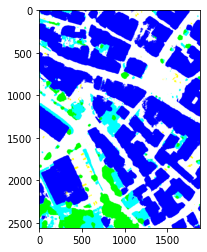

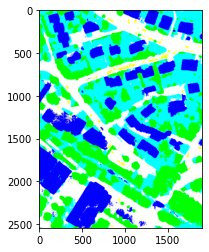

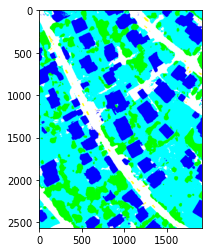

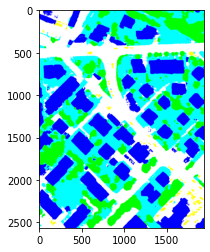

In [24]:
for p, id_ in zip(all_preds, test_ids):
    img = convert_to_color(p)
    plt.imshow(img) and plt.show()
    io.imsave('./inference_tile_{}.png'.format(id_), img)